# Прогнозирование оттока клиента

---

## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.  

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Заказчик имеет долгосрочную стратегию развития и расширения зоны предоставления услуг.

---

### Бизнес-проблематика


Уточнили у заказчика бизнес-метрики и проблематику.  

Сейчас это убытки, связанные с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования.  

Маркетологи компании выделяют две болевые точки:

+ Пользователю предложили промокоды, но он не собирался уходить (классический пример False Positive на нашем языке);
+ Пользователю ничего не предложили и он ушёл (как говорится, False Negative).

Помимо loss-метрики ROC-AUC для нас, заказчик хочет какую-нибудь интерпретируемую метрику, чтобы руководство могло понять отчет. Будем использовать метрику качества accuracy и приведем матрицу ошибок для убедительного отчета

---

## Введение

In [ ]:
# ! gdown 105ZR__zKS0dRrBtRGCNgDwVkAxjUijvj
# ! gdown 1jQ9x9Bttx6NAA7vkcqWOXC4Ki-oc6Vni
# ! gdown 1tt-wk6b2FwuLCQvC1eXeqHF2a_sTYbFP
# ! gdown 1JjxbE-FboOZbjkvi8tSJpWgsl7Rx_EJQ

In [ ]:
# Import labraries
# ! pip install phik
# ! pip install inflection
# ! pip install catboost

import warnings
from functools import reduce

import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from tabulate import tabulate

from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    roc_curve,
    confusion_matrix,
)


plt.style.use('dark_background')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
cm = sns.dark_palette("purple", as_cmap=True)

In [ ]:
# Fixed random
RANDOM_STATE = 310723

In [ ]:
# Upload the data
try:
  df = pd.read_csv('/content/personal_new.csv')
  contract = pd.read_csv('/content/contract_new.csv', parse_dates=[1])
  internet = pd.read_csv('/content/internet_new.csv')
  phone = pd.read_csv('/content/phone_new.csv')

except:
  df = pd.read_csv('/datasets/personal_new.csv')
  contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=[1])
  internet = pd.read_csv('/datasets/internet_new.csv')
  phone = pd.read_csv('/datasets/phone_new.csv')


In [ ]:
# List with all datasets
data = [df, contract, internet, phone]

### Необходимые функции

In [ ]:
# Function for displaying basic election information
def data_info(data):
    '''
    Explore the data.

    Args:
        data: pd.DataFrame - the main dataset for analysis

    Returns:
        Random 5 rows of the dataframe,
        General information about the data size and features,
        Basic statistics of the data,
        Distribution of values in the features,
        Proportions of missing values in the data

    '''
    # Get the dictionary of global variables
    global_vars = globals()

    # Find the variable name based on the dataset object
    dataset_name = next(
        name for name, value in global_vars.items() if value is data)

    # Print the dataset name before analyzing the data
    print(f'\033[1m\033[4mDataset: {dataset_name.upper()}\033[0m\n')

    # Output random 5 rows of data
    print("\033[1mRandom 5 rows of data:\033[0m")
    print(tabulate(
        data.sample(5), headers='keys',
        tablefmt='fancy_grid', showindex=False)
    )
    print(data.shape)

    # Output general information about the data (data types of features)
    print("\n\033[1mGeneral information about the data:\033[0m")
    print(tabulate(
        pd.DataFrame(data.dtypes).T, headers='keys',
        tablefmt='fancy_grid', showindex=False)
    )

    # Output basic statistics of the data (mean, std, min, max, etc.)
    print("\n\033[1mBasic statistics of the data:\033[0m")
    print(tabulate(
        data.describe(include='all').transpose(),
        headers='keys', tablefmt='fancy_grid')
    )

    # Output distribution of values in each feature
    print("\n\033[1mDistribution of values in the features:\033[0m")
    for column in data.columns:
        print(f"\n\033[1mFeature: {column}\033[0m")
        print(tabulate(
            data[column].value_counts(ascending=False, dropna=False).head().reset_index(),
            headers='keys', tablefmt='fancy_grid', showindex=False)
    )

    # Output proportions of missing values for each feature
    print("\n\033[1mProportions of missing values:\033[0m")
    print(tabulate(pd.DataFrame(
        data.isna().mean()).T, headers='keys',
        tablefmt='fancy_grid', showindex=False)
    )


## Первичный осмотр данных

Посмотрим на основные показатели статистик и распределения в нагих выборках

In [ ]:
# Exploring the personal
data_info(df)

Dataset: DF

Random 5 rows of data:
╒══════════════╤══════════╤═════════════════╤═══════════╤══════════════╕
│ customerID   │ gender   │   SeniorCitizen │ Partner   │ Dependents   │
╞══════════════╪══════════╪═════════════════╪═══════════╪══════════════╡
│ 1013-QCWAM   │ Female   │               1 │ Yes       │ No           │
├──────────────┼──────────┼─────────────────┼───────────┼──────────────┤
│ 2472-OVKUP   │ Male     │               0 │ Yes       │ No           │
├──────────────┼──────────┼─────────────────┼───────────┼──────────────┤
│ 6408-OTUBZ   │ Female   │               0 │ No        │ No           │
├──────────────┼──────────┼─────────────────┼───────────┼──────────────┤
│ 6179-GJPSO   │ Female   │               1 │ No        │ No           │
├──────────────┼──────────┼─────────────────┼───────────┼──────────────┤
│ 6725-TPKJO   │ Male     │               0 │ No        │ No           │
╘══════════════╧══════════╧═════════════════╧═══════════╧══════════════╛
(7043, 5)

Gene

Как мы видим, использование данных предыдущими разработчиками оставило следы, также возможно это ошибка сбора данных, признак SeniorCitizen представлен бинарно,в дальнейшем переведем его в строковый вид равным аналогичным значениям из других признаков для удобства последующего кодирования

In [ ]:
# Exploring the contract
data_info(contract)

Dataset: CONTRACT

Random 5 rows of data:
╒══════════════╤═════════════════════╤════════════╤════════════════╤════════════════════╤═══════════════════════════╤══════════════════╤════════════════╕
│ customerID   │ BeginDate           │ EndDate    │ Type           │ PaperlessBilling   │ PaymentMethod             │   MonthlyCharges │   TotalCharges │
╞══════════════╪═════════════════════╪════════════╪════════════════╪════════════════════╪═══════════════════════════╪══════════════════╪════════════════╡
│ 2546-KZAAT   │ 2015-10-01 00:00:00 │ No         │ One year       │ Yes                │ Mailed check              │            75.4  │        4156.05 │
├──────────────┼─────────────────────┼────────────┼────────────────┼────────────────────┼───────────────────────────┼──────────────────┼────────────────┤
│ 2262-SLNVK   │ 2020-01-01 00:00:00 │ No         │ Month-to-month │ No                 │ Electronic check          │            70.1  │          72.2  │
├──────────────┼──────────────────

По выборке contract мы видим возможность создания целевого признака, признак EndDate содержит необходимые данные оттока клиентов для нашей задачи

Так как признаки дат для модели в нашем случае не имею смысла, мы можем их сохранить преобразовав в новый признак продолжительность пользования услугами компании, что позволит нам исключить признаки дат, устранить утечку целевого признака и добавить эффективности обучения

Также наблюдаем ошибку выгрузки данных признак TotalCharges содержит неверный формат, а также присутствует предположительно нулевое значение, которое в типе строка является пустой строкой, необходимо в дальнейшем принять меры

In [ ]:
# Exploring the internet
data_info(internet)

Dataset: INTERNET

Random 5 rows of data:
╒══════════════╤═══════════════════╤══════════════════╤════════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════════╕
│ customerID   │ InternetService   │ OnlineSecurity   │ OnlineBackup   │ DeviceProtection   │ TechSupport   │ StreamingTV   │ StreamingMovies   │
╞══════════════╪═══════════════════╪══════════════════╪════════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════════╡
│ 5013-SBUIH   │ Fiber optic       │ Yes              │ Yes            │ No                 │ Yes           │ Yes           │ Yes               │
├──────────────┼───────────────────┼──────────────────┼────────────────┼────────────────────┼───────────────┼───────────────┼───────────────────┤
│ 5792-JALQC   │ DSL               │ Yes              │ No             │ Yes                │ No            │ No            │ No                │
├──────────────┼───────────────────┼──────────────────┼────────────────┼──────────

Все признаки корректные бинарные, но количество объектов меньше, чем в предыдущих выборках, при объединении получим пропущенные значения, это может иметь значение неиспользования дополнительных услуг компании и можем соответствующе заполнить

In [ ]:
# Exploring the phone
data_info(phone)

Dataset: PHONE

Random 5 rows of data:
╒══════════════╤═════════════════╕
│ customerID   │ MultipleLines   │
╞══════════════╪═════════════════╡
│ 4686-GEFRM   │ Yes             │
├──────────────┼─────────────────┤
│ 0430-IHCDJ   │ Yes             │
├──────────────┼─────────────────┤
│ 7483-IQWIB   │ Yes             │
├──────────────┼─────────────────┤
│ 6457-GIRWB   │ No              │
├──────────────┼─────────────────┤
│ 7493-GVFIO   │ No              │
╘══════════════╧═════════════════╛
(6361, 2)

General information about the data:
╒══════════════╤═════════════════╕
│ customerID   │ MultipleLines   │
╞══════════════╪═════════════════╡
│ object       │ object          │
╘══════════════╧═════════════════╛

Basic statistics of the data:
╒═══════════════╤═════════╤══════════╤════════════╤════════╕
│               │   count │   unique │ top        │   freq │
╞═══════════════╪═════════╪══════════╪════════════╪════════╡
│ customerID    │    6361 │     6361 │ 5575-GNVDE │      1 │
├────────

---

### Промежуточный вывод:

Были выявлены некоторые проблемы и наблюдения, а именно:
- Названия признаков имеем различные регистры (PascalCase, camelCase) приведем к underscore_case для удобства
- Во всех выборках присутствует признак идентификатор пользователя, по нему объединим все выборки в один датасет
- В двух выборках размер данных меньше, при объединении получим пропущенные значения, которые являются явным отсуствием пользователя в выборке и имеют значение неиспользования пользователем данных услуг ('No') или просто они еще не были добавлены в базу данных

- Обнаружены ошибки выгрузки данных (неправильный тип признака), учтем это при предобработке данных и сообщим заказчику
- Имеются следы работы предыдущей команды разработки (или ошибка сбора/выгрузки  данных), вернем к идентичному остальным признакам виду
- Большая часть признаков является бинарными со значениями Да или Нет, также несколько Многоклассовых признаков, учтем при кодировании признаков для исследрвания моделей
- На текущем этапе данные пропусков не имеют, дубликаты в контексте нашей задачи также рассматривать нет необходимости

---

## Предобработка данных

---

Объединим наши данные для удобства предобработки

In [ ]:
# Function for combining DataFrame by CustomerID column
def merge_data(first_data, second_data):
    return pd.merge(first_data, second_data, on='customerID', how='left')

# Use reduce to combine all the samples with the main DataFrame
df = reduce(merge_data, data[1:], df)

Исправим регистр и посмотрим на пропуски и данные

In [ ]:
# Lets bring the signs to the snake_case
df.columns = df.columns.map(lambda x: inflection.underscore(x))

# Check it out
df.isna().mean()

customer_id          0.000000
gender               0.000000
senior_citizen       0.000000
partner              0.000000
dependents           0.000000
begin_date           0.000000
end_date             0.000000
type                 0.000000
paperless_billing    0.000000
payment_method       0.000000
monthly_charges      0.000000
total_charges        0.000000
internet_service     0.216669
online_security      0.216669
online_backup        0.216669
device_protection    0.216669
tech_support         0.216669
streaming_tv         0.216669
streaming_movies     0.216669
multiple_lines       0.096834
dtype: float64

In [ ]:
# Look at the data
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No


In [ ]:
# Look at the empty values of the total_charges attribute
df[df['total_charges'] == ' ']

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Yes


В признаке общих оплат видим, что значение равное пустой строке из за типа данных строки присутствует у новых пользователей значит мы можем заполнить это значение нулем

Перед началом работы с пропусками необходимо исправить уже найденные недостатки:
- добавить целевой признак
- добавить признак на основе дат
- исправить найденные ошибки


In [ ]:
# Replace the total_charges attribute type with
df['total_charges'] = df['total_charges'].replace(' ', 0).astype(float)

# Creating the target feature
df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

# Replacing the values in the end_date attribute with the upload date
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

df['senior_citizen'] = df['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Changing the data type in the attributes with the date
df['end_date'] = pd.to_datetime(df['end_date'])
df['begin_date'] = pd.to_datetime(df['begin_date'])

# Creating a new feature - the duration of the clients use of the companys services
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

In [ ]:
# Check
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,Male,No,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,Female,No,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,0,153


In [ ]:
# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   float64       
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

✅ Отлично

Посмотрим на баланс в целевом признаке

In [ ]:
# Shares of target attribute classes
df['churn'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: churn, dtype: float64

Классы не сбалансированы, учтем при исследовании моделей

## Исследовательский анализ данных

---

Теперь посмотрим на данные с пропусками чтобы увидеть зависимости


In [ ]:
# Perform logical indexing and look at the information about the data
df_miss_value = df[df.isna().any(axis=1)]

In [ ]:
data_info(df_miss_value)

Dataset: DF_MISS_VALUE

Random 5 rows of data:
╒═══════════════╤══════════╤══════════════════╤═══════════╤══════════════╤═════════════════════╤═════════════════════╤════════════════╤═════════════════════╤═══════════════════════════╤═══════════════════╤═════════════════╤════════════════════╤═══════════════════╤═════════════════╤═════════════════════╤════════════════╤════════════════╤════════════════════╤══════════════════╤═════════╤════════════╕
│ customer_id   │ gender   │ senior_citizen   │ partner   │ dependents   │ begin_date          │ end_date            │ type           │ paperless_billing   │ payment_method            │   monthly_charges │   total_charges │   internet_service │   online_security │   online_backup │   device_protection │   tech_support │   streaming_tv │   streaming_movies │ multiple_lines   │   churn │   duration │
╞═══════════════╪══════════╪══════════════════╪═══════════╪══════════════╪═════════════════════╪═════════════════════╪════════════════╪══════════════

Как мы видим, значения пропущены в одинаковом количестве (1526) во всех признаках кроме признака multiple_lines (1184) так как это разные выгрузки

Можно провести дополнительное исследование для того чтобы понять, каким значением можно заполнить отдельные пропуски в признаках, а также уточнить у заказчика по всем признакам выгруженным из базы данных, где размер меньше чем у первых двух выборок

Пока что заполним данные значением No и посмотрим на результат исследования

In [ ]:
# Fill in the gaps with a label
df = df.fillna('No')

Посмотрим на приходы пользователей по годам

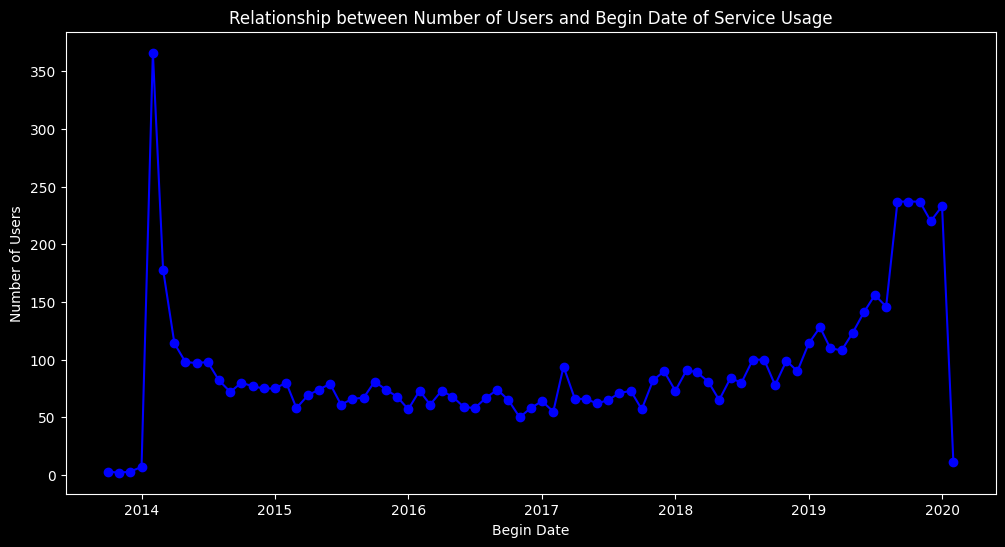

In [ ]:
# Group the data by the 'begin_date' feature and count the number of users in each group
user_counts_by_begin_date = df['begin_date'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(
    user_counts_by_begin_date.index,
    user_counts_by_begin_date.values,
    marker='o', linestyle='-', color='b')

# Set labels and titles for the axes and the plot
plt.xlabel('Begin Date')
plt.ylabel('Number of Users')
plt.title('Relationship between Number of Users and Begin Date of Service Usage')

# Show the plot
plt.show()

Как мы видим выделяется два пика прихода пользователей в 2014 году и сильное нарастание с 2019 по 2020, также необходимо посмотреть на общую сумму оплаты по годам

In [ ]:
# Extract the year from the 'begin_date' column
df['year'] = pd.to_datetime(df['begin_date']).dt.year

# Group the data by the 'year' and 'churn' column and calculate the total charges for each group
year_churn_total = (
    df.groupby(['year', 'churn'])['total_charges']
                 .agg(['count', 'sum'])
                 .reset_index())
year_total = (
    df.groupby(['year'])['total_charges']
                 .agg(['count', 'sum'])
                 .reset_index())

In [ ]:
# Check
year_churn_total.style.background_gradient(cmap=cm)

,year,churn,count,sum
0,2013,0,6,47426.570000
1,2013,1,2,4285.120000
2,2014,0,914,4851341.600000
3,2014,1,430,1277560.540000
4,2015,0,574,2252826.340000
5,2015,1,278,719068.180000
6,2016,0,575,1687866.390000
7,2016,1,188,371158.010000
8,2017,0,739,1535405.940000
9,2017,1,106,169126.290000


Можем заметить, что в 2014 году не самая большая часть пользователей суммарно оплатили больше в 2 раза, чем в следующий год и еще больше, чем в последующие, возможно это связано со активным стартом работы компании и акциями на старте, в 2019 году есть пиковый приход пользователей, но оплат гораздо меньше, скорее всего также акция на повышение лояльности пользователей, в основном кассовые пользователи - неооточны

Посмотрим данные с пропусками за 2014 год, изучим тип оплаты подписки пользователей

In [ ]:
# Count the occurrences of each unique value in the 'type' column for the year 2014
df.query('year == 2014')[['churn', 'type']].value_counts().to_frame()

0
churn type               
0     Two year        680
1     Two year        270
0     One year        184
1     One year        108
      Month-to-month   52
0     Month-to-month   50

Да, все верно, основная часть пользователей приобрела подписку сразу на 2 года, что и принесло компании такую сумму

Посмотрим теперь на 2019 год

In [ ]:
# Count the occurrences of each unique value in the 'type' column for the year 2019
df.query('year == 2019')[['churn', 'type']].value_counts().to_frame()

0
churn type                
0     Month-to-month  1742
      One year         123
      Two year          67
1     Month-to-month    23
      One year           2

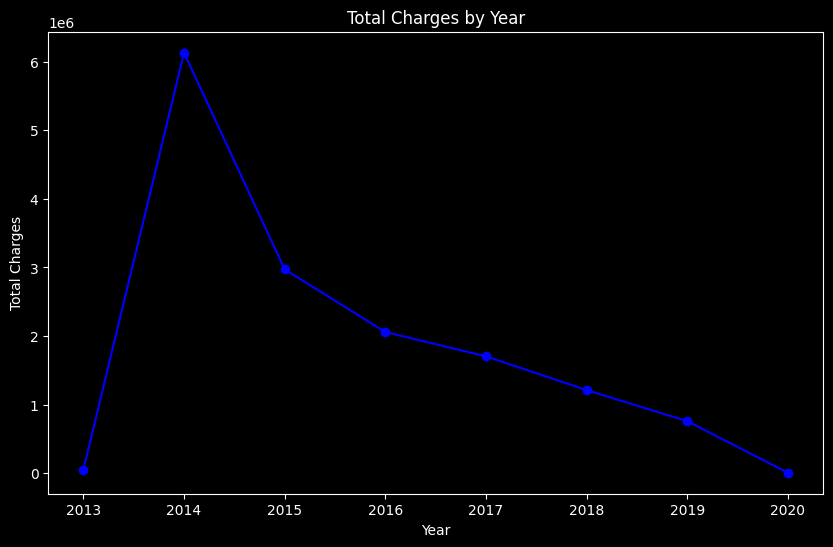

In [ ]:
# Visualize the results using a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    year_total['year'],
    year_total['sum'],
    marker='o', linestyle='-', color='b')

# Set labels and titles for the axes and the plot
plt.xlabel('Year')
plt.ylabel('Total Charges')
plt.title('Total Charges by Year')

# Show the plot
plt.show()

Также наши догадки подтверждены, оплаты подключены помесячные и поэтому такая разница в суммарных оплатах

Проанализируем распределение средних значений суммарных платежей по пользователям, которые пользуются дополнительными сервисами.

Это даст представление о том, как сервисы влияют
на общую сумму платежей пользователей и влияет ли это на их поведение при оттоке.

Этот анализ поможет нам понять взаимосвязь между
использованием сервисов и платежным поведением пользователей, что может быть полезно для принятия бизнес-решений.

In [ ]:
# Distribution of users using the additional service
df.streaming_movies.value_counts()

No     4311
Yes    2732
Name: streaming_movies, dtype: int64

In [ ]:
'''
Let's look at the distribution of average values of total payments
by users using the additional service streaming_movies
'''
stream_total_charges = (
    df.groupby(['internet_service', 'streaming_movies', 'streaming_tv', ])['total_charges']
      .agg(['count','mean', 'median']).reset_index())

stream_total_charges.style.background_gradient(cmap=cm)

,internet_service,streaming_movies,streaming_tv,count,mean,median
0,DSL,No,No,1113,1152.827358,704.390000
1,DSL,No,Yes,327,2093.638716,1743.140000
2,DSL,Yes,No,351,2046.556410,1720.940000
3,DSL,Yes,Yes,630,3316.621794,3191.820000
4,Fiber optic,No,No,905,1638.491514,1017.900000
5,Fiber optic,No,Yes,440,2555.373114,1995.250000
6,Fiber optic,Yes,No,441,2559.750703,2062.280000
7,Fiber optic,Yes,Yes,1310,4144.884809,3855.125000
8,No,No,No,1526,626.979528,495.360000


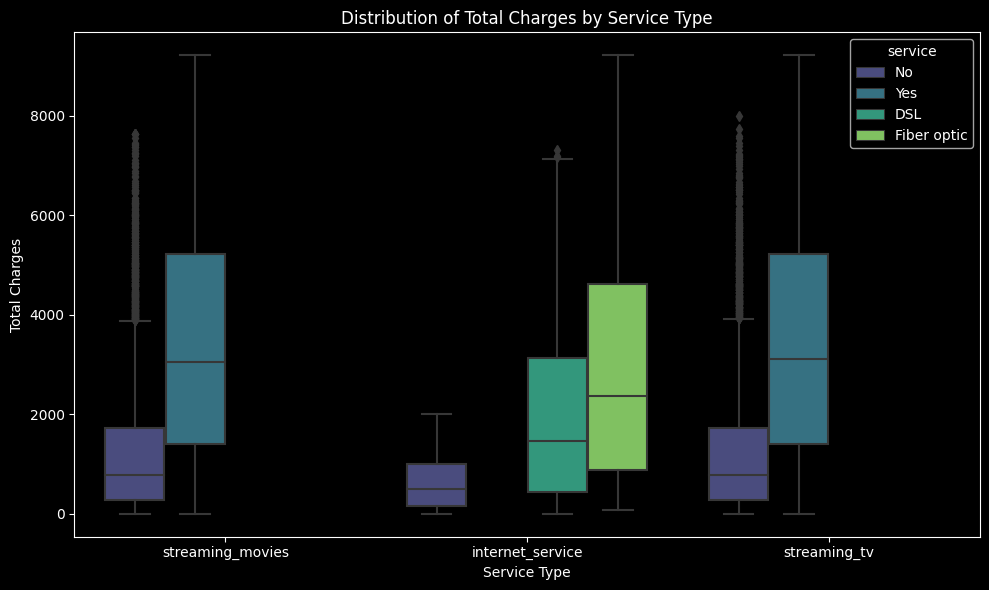

In [ ]:
# Combine the values of streaming_movies, internet_service and streaming_tv into one column
melted_df = df.melt(id_vars='total_charges', value_vars=['streaming_movies', 'internet_service', 'streaming_tv'],
                   var_name='service_type', value_name='service')

# Creating a graph using Seaborn for the service_type dependency on total_charges
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_df, x='service_type', y='total_charges', hue='service', palette='viridis', showfliers=True)
plt.xlabel('Service Type')
plt.ylabel('Total Charges')
plt.title('Distribution of Total Charges by Service Type')
plt.tight_layout()
plt.show()

На основе этих данных мы можем сделать выводы:

- Пользователи с интернет-сервисом DSL, не использующие сервисы потокового просмотра фильмов и телевидения, имеют самые низкие средние общие платежи (среднее: 1152.83) среди всех групп.
- Пользователи с интернет-сервисом Fiber optic, которые используют оба сервиса потокового просмотра фильмов и телевидения, имеют самые высокие средние общие платежи (среднее: 4144.88) среди всех групп.
- Пользователи с интернет-сервисом Fiber optic в целом имеют более высокие средние общие платежи по сравнению с пользователями DSL.
- Группа с маркерами в столбцах 'internet_service', 'streaming_movies' и 'streaming_tv' (No) имеет самые низкие средние общие платежи (среднее: 626.98) по сравнению с другими группами с указанными услугами.
- Эти наблюдения указывают на то, что тип интернет-сервиса и использование потоковых сервисов могут влиять на средние общие платежи пользователей.
- Пользователи с интернет-сервисом Fiber optic, которые используют оба потоковых сервиса, имеют самые высокие платежи, в то время как пользователи с пропущенной информацией имеют самые низкие платежи в среднем.

Посмотрим на распределение оттока клиентов в сравнении с продолжительностью пользования услуг компании

In [ ]:
(
    df.groupby(['churn'])['duration']
      .agg(['count', 'median'])
      .reset_index()
      .style.background_gradient(cmap=cm)
)

,churn,count,median
0,0,5942,702.000000
1,1,1101,915.000000


In [ ]:
(
    df.groupby(['year', 'churn'])['duration']
      .agg(['count', 'median'])
      .reset_index()
      .style.background_gradient(cmap=cm)
)

,year,churn,count,median
0,2013,0,6,2298.500000
1,2013,1,2,867.500000
2,2014,0,914,2102.000000
3,2014,1,430,1127.000000
4,2015,0,574,1676.000000
5,2015,1,278,1035.000000
6,2016,0,575,1340.000000
7,2016,1,188,911.500000
8,2017,0,739,945.000000
9,2017,1,106,638.000000


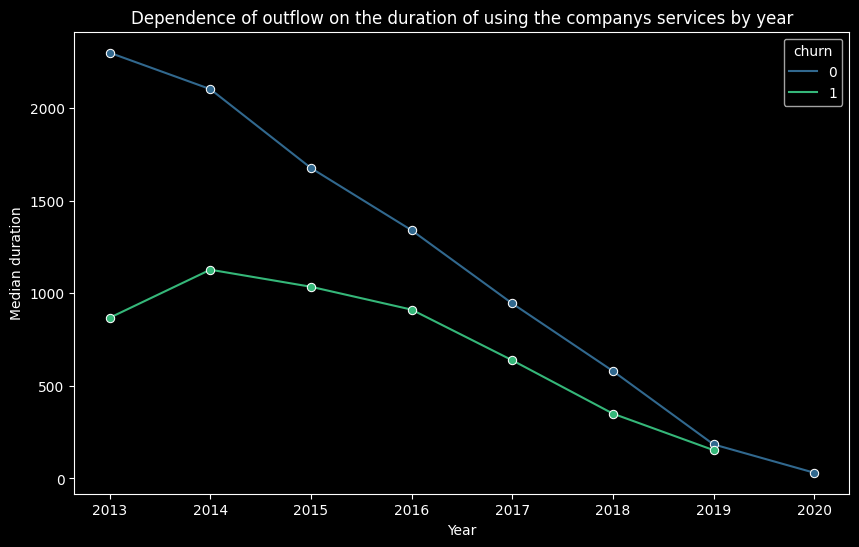

In [ ]:
# Grouping of data by year and outflow, as well as calculating the median duration of use of services
data = df.groupby(['year', 'churn'])['duration'].median().reset_index()

# Creating a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='year', y='duration',
    hue='churn', data=data,
    marker='o', palette='viridis')

# Setting up axes and heading
plt.xlabel('Year')
plt.ylabel('Median duration')
plt.title('Dependence of outflow on the duration of using the companys services by year')

plt.show()

Видим, что отточные пользователи чаще являются клиентами компании более  2-х с половиной лет (~915 дней)  
Отток пользователей с 2014 года только падает а новые пользователи растут

Посмотрим на другие распределения и попробуем составить описание среднего клиента

In [ ]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration,year
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,0,31,2020
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0,1036,2017
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0,123,2019
3,7795-CFOCW,Male,No,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,0,1371,2016
4,9237-HQITU,Female,No,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,0,153,2019


In [ ]:
# Cat features
cat = df.drop(
    ['monthly_charges', 'total_charges', 'duration',
     'customer_id', 'begin_date', 'end_date', 'churn'],
    axis=1
).columns.to_list()
cat

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'type',
 'paperless_billing',
 'payment_method',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'year']

Посмотрим распределение категориальных данных наглядно

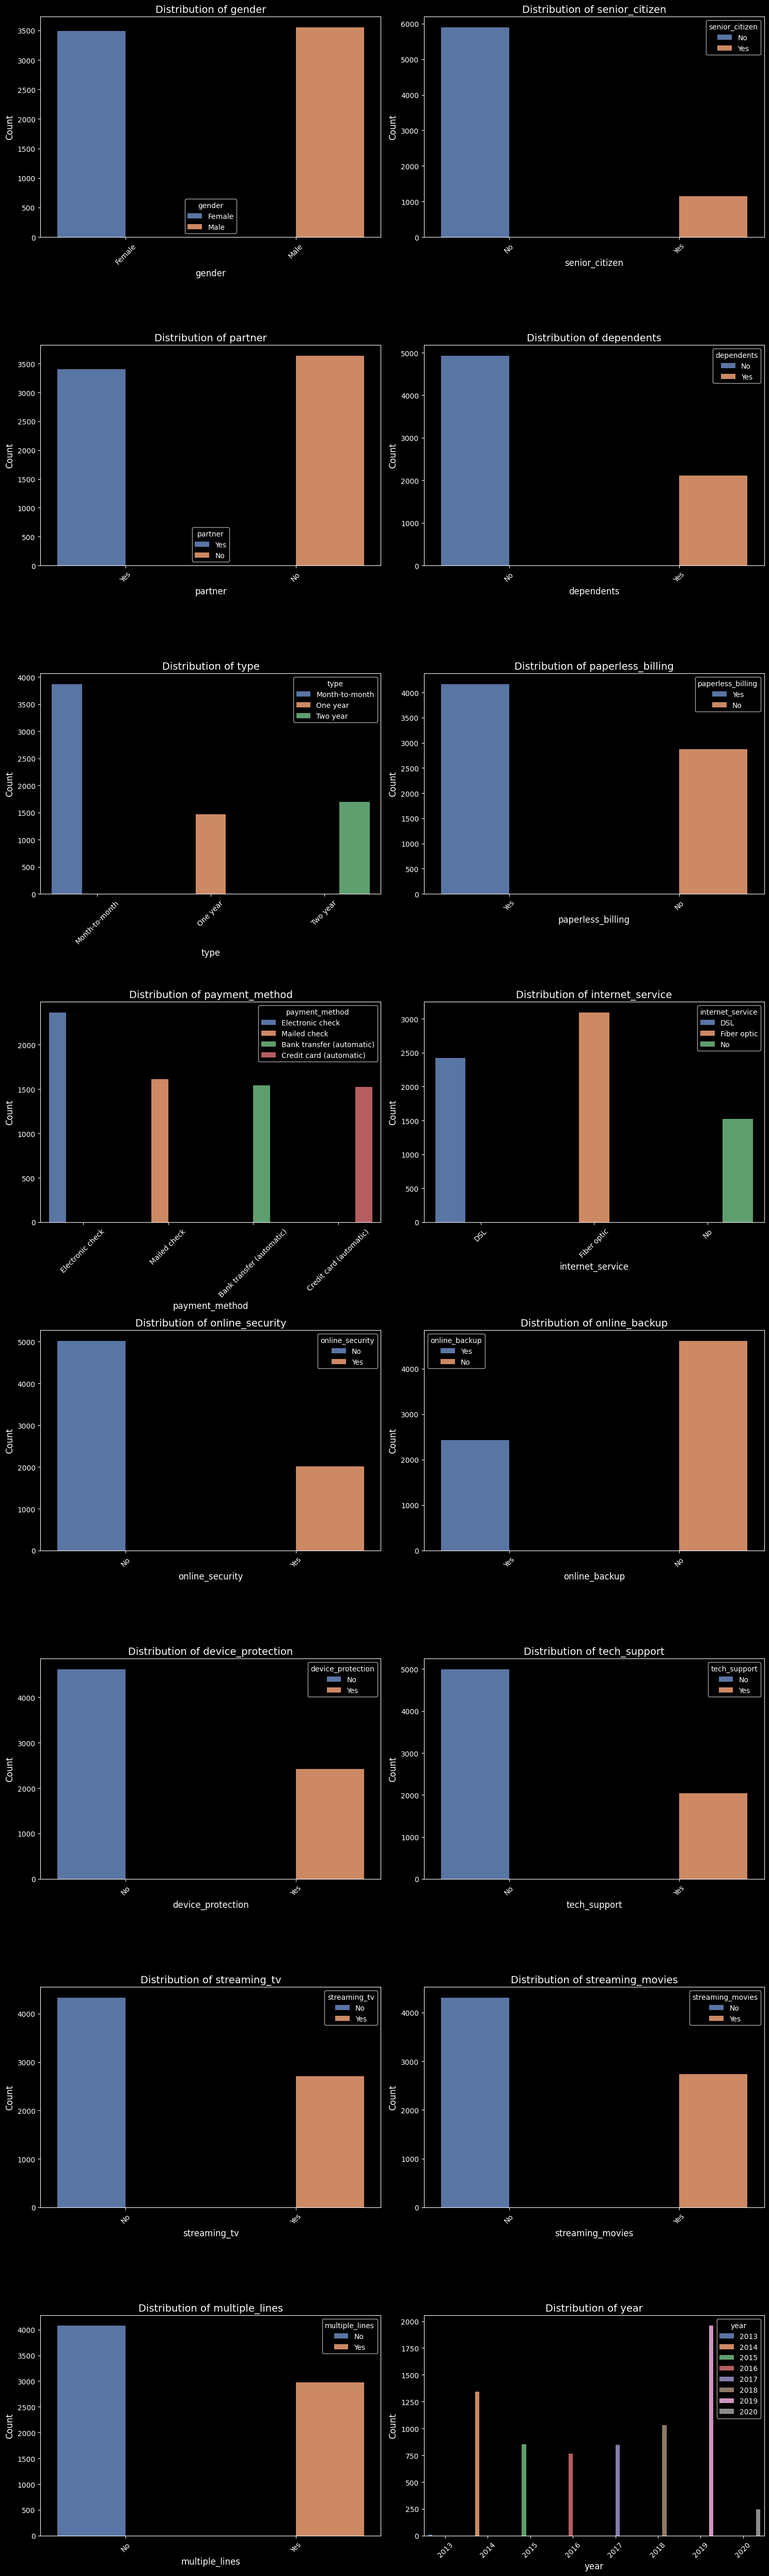

In [ ]:
# Creating a matplotlib grid with 8 rows and 2 columns
fig, axes = plt.subplots(8, 2, figsize=(15, 50))

# Convert 2D axes array to 1D array for ease of iteration
axes = axes.flatten()

# Use a loop to draw a histogram on each subgraph
for i, feature in enumerate(cat):
    sns.countplot(x=feature, hue=feature, data=df, palette='deep', ax=axes[i])

    # Setting up axes and headers
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# We place graphs on the grid
plt.tight_layout()

# Showing graphs
plt.show()

- Распределение пользователей по половому признаку примерно одинаково, также как и наличие партнера
- Большинство - не пенсионеры и не имеют никого на иждивении
- Основная часть пользователей используют оптоволокно, чуть меньше  пользователей подключены по DSL
- Оплата помесячная
- Получают счет за услуги на электронную почту и оплата в онлайн

- Большая часть пользователей не пользуется дополнительными услугами компании

---

Посмотрим корреляцию наших данных

In [ ]:
phik_corr = df.phik_matrix(interval_cols=[
    'monthly_charges',
    'total_charges',
    'duration'
])

In [ ]:
(
    phik_corr['churn'].sort_values(ascending=False)
                      .to_frame()
                      .style.background_gradient(cmap=cm))

,churn
customer_id,1.000000
end_date,1.000000
churn,1.000000
year,0.479112
begin_date,0.450254
duration,0.374569
total_charges,0.302890
multiple_lines,0.261237
online_backup,0.229482
partner,0.226688


In [ ]:
# Corr matrix
phik_corr.style.background_gradient(cmap=cm)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration,year
customer_id,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
gender,1.000000,1.000000,0.000000,0.000000,0.000000,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000,0.031734
senior_citizen,1.000000,0.000000,1.000000,0.016992,0.324576,0.050862,0.090502,0.086231,0.242133,0.292725,0.304985,0.135650,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.086159,0.063315,0.077451
partner,1.000000,0.000000,0.016992,1.000000,0.652122,0.473514,0.177492,0.179736,0.013218,0.243008,0.203545,0.381958,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.226688,0.453688,0.491085
dependents,1.000000,0.000000,0.324576,0.652122,1.000000,0.208564,0.055518,0.147680,0.172593,0.224903,0.184366,0.084247,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.046871,0.198729,0.201007
begin_date,1.000000,0.011268,0.050862,0.473514,0.208564,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.192197,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.428109,0.450254,0.978521,1.000000
end_date,1.000000,0.018274,0.090502,0.177492,0.055518,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,0.117099,0.129611,0.203659,0.197691,0.112812,0.164794,0.177561,0.209337,1.000000,0.396342,0.494826
type,1.000000,0.000000,0.086231,0.179736,0.147680,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.094015,0.634155,0.627612
paperless_billing,1.000000,0.000000,0.242133,0.013218,0.172593,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.083398,0.026799,0.093409
payment_method,1.000000,0.000000,0.292725,0.243008,0.224903,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.214832,0.350964,0.484804


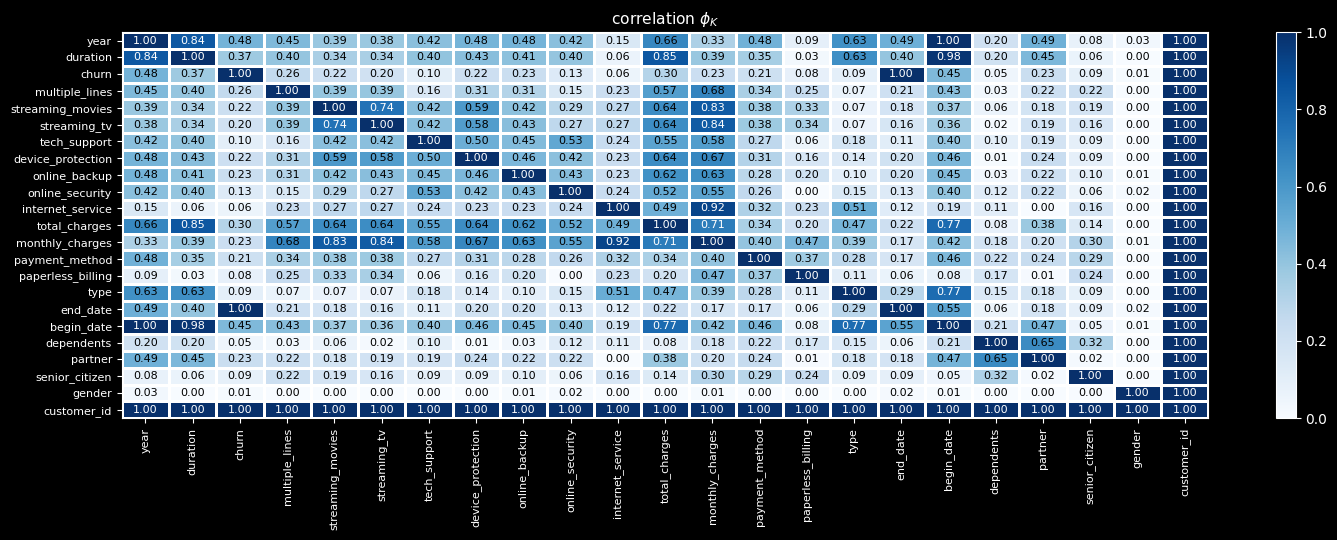

In [ ]:
# Plot a correlation matrix
plot_correlation_matrix(phik_corr.values, x_labels=phik_corr.columns, y_labels=phik_corr.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=.8,
                        figsize=(15,5.5))
plt.tight_layout()

Мы имеем очень высокую корреляцию только по сгенерированным признака и признакам дат, по остальным признакам в связи с заполнением пропущенных данных не видим мультиколлинеарности, а также логических зависимостей между признаками например принадлежащих к интернету

Также большая часть признаков имеет слабую или очень слабую зависимость к целевой переменной

И только 4 признака около средней зависимости, возможно для улучшения качества моделей необходимо сгенерировать еще дополнительные признаки и уточнить информацию у заказчика по поводу подсвеченной ранее проблемы с пропусками

Исключим признаки которые имеют корреляцию меньше 0.09

Также видим, что id пользователя максимально коррелирует со всеми признаками
Можно будет провести дополнительное исследование
---

Удалим ненужные переменные созданные во время анализа

In [ ]:
# Deleting the 'axes' variable
del axes
# Deleting the 'fig' variable
del fig
# Deleting the 'data' variable
del data
# Deleting the 'df_miss_value' variable
del df_miss_value
# Deleting the 'i' variable
del i
# Deleting the 'melted_df' variable
del melted_df
# Deleting the 'stream_total_charges' variable
del stream_total_charges
# Deleting the 'user_counts_by_begin_date' variable
del user_counts_by_begin_date
# Deleting the 'year_churn_total' variable
del year_churn_total
# Deleting the 'year_total' variable
del year_total

Перейдем к исследованию моделей для определения отточности пользователей

## Исследование моделей

Разобьем данные на тренировочную и тестовую выборку с соблюдением баланса по целевому признаку и зафиксируем случайность

In [ ]:
# Split into samples
train, test = train_test_split(
    df, test_size=.25,
    stratify=df['churn'], random_state=RANDOM_STATE)

In [ ]:
X = train.drop(
    ['customer_id', 'begin_date', 'end_date', 'churn',
     'year', 'senior_citizen', 'paperless_billing',
     'internet_service',	'dependents',	'gender'],
    axis=1
).columns

cat = train.drop(
    ['monthly_charges', 'total_charges', 'duration',
     'customer_id', 'begin_date', 'end_date', 'churn',
     'year', 'senior_citizen', 'paperless_billing',
     'internet_service',	'dependents',	'gender'],
    axis=1
).columns.to_list()

y = ['churn']

In [ ]:
# Check
df[cat].describe()

,partner,type,payment_method,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,3,4,2,2,2,2,2,2,2
top,No,Month-to-month,Electronic check,No,No,No,No,No,No,No
freq,3641,3875,2365,5024,4614,4621,4999,4336,4311,4072


In [ ]:
print(f'Размер тренировочной выборки: {len(train)}, доля от изначальных данных {len(train)/len(df):.2f}')
print(f'Размер тестовой выборки: {len(test)}, доля от изначальных данных {len(test)/len(df):.2f}')
print(f'Размер изначального датасета: {len(df)}')
print(f'Размер выборок вмест: {len(train) + len(test)}')

Размер тренировочной выборки: 5282, доля от изначальных данных 0.75
Размер тестовой выборки: 1761, доля от изначальных данных 0.25
Размер изначального датасета: 7043
Размер выборок вмест: 7043


Отлично

### Baseline

Создадим бейзлайн модель которая будет случайно предсказывать отточных клиентов, для того, чтобы понимать имеют ли смысл наши исследования и сравнивать качество это будет логистическая регрессия

#### LogisticRegression

Посмотрим на модель логистической регрессии  


Необходимо преобразовать категориальные (OHE) и непрерывные признаки (MinMax)  
Нам не нужно балансировать классы вручную, так как мы можем установить параметр балансировки классов внутри модели  
Также модель не чувствительна к мультиколлинеарности, так как мы используем параметры регуляризации L2-норму

In [ ]:
# Numerical feature columns
numerical_features = ['monthly_charges', 'total_charges',	'duration']

# Create the ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
        ('num', MinMaxScaler(), numerical_features)
    ])

# Create the Logistic Regression model
log_model = LogisticRegression(random_state=RANDOM_STATE)

# Create the pipeline combining the preprocessor and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', log_model)])

# Define the hyperparameters you want to tune
param_grid = {
    'model__C': [0.1, 1, 0.01, 0.001],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [100, 200, 400]
}

# Create the GridSearchCV object with roc_auc as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the model to the data
grid_search.fit(train[X], train[y])

# Save best model
log_model_best = grid_search.best_estimator_

# Print the best hyperparameters and corresponding roc_auc score
print("Best parameters:", log_best_params:=grid_search.best_params_)
print("Best ROC AUC:", log_best_score:=grid_search.best_score_)

Best parameters: {'model__C': 20, 'model__class_weight': 'balanced', 'model__max_iter': 100, 'model__solver': 'liblinear'}
Best ROC AUC: 0.7729466297191909


Мы получили метрику ниже которой результаты не будут иметь смысла

### RandomForestClassifier

Посмотрим на модель случайного леса

Для модели необходимо преобразовать категориальные признаки и непрерывные

In [ ]:
# Create the ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), cat),
        ('num', MinMaxScaler(), numerical_features)
    ])

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Create the pipeline combining the preprocessor and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', rf_model)])

# Define the hyperparameters you want to tune
param_grid = {
    'model__n_estimators': [400, 500, 700],
    'model__max_depth': range(6,8),
    'model__min_samples_split': range(6, 10),
    'model__criterion': ['log_loss']
}

# Create the GridSearchCV object with roc_auc as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the model to the data
grid_search.fit(train[X], train[y])

# Get the best model from the grid search
rf_model_best = grid_search.best_estimator_

# Print the best hyperparameters and corresponding roc_auc score
print("Best Hyperparameters:", rf_best_params:=grid_search.best_params_)
print("Best ROC AUC:", rf_best_score:=grid_search.best_score_)

Best Hyperparameters: {'model__criterion': 'log_loss', 'model__max_depth': 7, 'model__min_samples_split': 7, 'model__n_estimators': 700}
Best ROC AUC: 0.837766372668536


Модель случайного леса показала хороший результат, но не удовлетворяющий установленному уровню в ROC_AUC = 0.85,  
результат превзошел бейзлайн модель

### CatBoostClassifier

Посмотрим на модель категориального бустинга

Для нее не требуется каких либо подготовок признаков, модель отлично справляется с любыми данными самостоятельно даже при настройках по умолчанию

Мы немного переберем параметры для нахождения лучшей метрики

In [ ]:
# Creating a CatBoostClassifier model
cat_model = CatBoostClassifier()

# Setting the parameters that need to be selected
param_grid = {
    'iterations': [700, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'verbose': [False],
    'l2_leaf_reg': [1, 0.1, 0.5],
    'auto_class_weights': ['Balanced']
}

# Creating a GridSearchCV object
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5, scoring='roc_auc')

# Starting grid search
grid_search.fit(train[X], train[y], cat_features=cat)
cat_best_model = grid_search.best_estimator_

# Output of the best parameters and the corresponding metric
print("Best parameters:", cat_best_params:=grid_search.best_params_)
print("Best ROC AUC:", cat_best_score:=grid_search.best_score_)

Best parameters: {'auto_class_weights': 'Balanced', 'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1, 'verbose': False}
Best ROC AUC: 0.9115439156479415


### Вывод:

Мы провели исследование трех моделей и получили результаты

Занесем данные метрик в таблицу и посмотрим на результаты исследования

In [ ]:
# Table with the final results of the model study
result = pd.DataFrame(
    {
        'model': ['LogisticRegression',
                  'RandomForestClassifier',
                  'CatBoostClassifier'],
        'score_roc_auc': [log_best_score,
                          rf_best_score,
                          cat_best_score]}
)

In [ ]:
# By how many percent did the best model outperform the baseline model
difference = ((cat_best_score - log_best_score) / log_best_score) * 100

print(f'На {difference:.2f} % лучшая модель CatBoostClassifier превзошла бейзлайн модель LogisticRegression')


На 18.05 % лучшая модель CatBoostClassifier превзошла бейзлайн модель LogisticRegression


In [ ]:
result.style.background_gradient(cmap=cm)

,model,score_roc_auc
0,LogisticRegression,0.772192
1,RandomForestClassifier,0.837766
2,CatBoostClassifier,0.911544


Наши модели превзошли бейзлайн  
+ RandomForestClassifier, превзошла бейзлайн, но не перешла установленный порог
+ CatBoostClassifier, также превзошла бейзлайн, но в дополнении к этому еще и зашла в метрике ROC_AUC выше необходимой границы, поэтому тестировать будем именно бустинг и получим финальную метрику

## Тестирование финальной модели

Протестируем нашу лучшую модель на данных, которых она еще не видела, на тестовой выборке и посмотрим на результат

In [ ]:
# Get predictions
pred_prob = cat_best_model.predict_proba(test[X])[:, 1]
predict = cat_best_model.predict(test[X])

In [ ]:
print(f'ROC_AUC score: {roc_auc_score(test[y], pred_prob)}')
print(f'Accuracy score: {accuracy_score(test[y], predict)}')

ROC_AUC score: 0.9183665728618623
Accuracy score: 0.8966496308915389


### Анализ финальной модели



Теперь визуализируем обучение модели чтобы посмотреть на все данные, а также построим матрицу ошибок, чтобы увидеть какие значения получилось угадать лучше

### Важность признаков

Посмотрим на важность признаков для нашей финальной модели

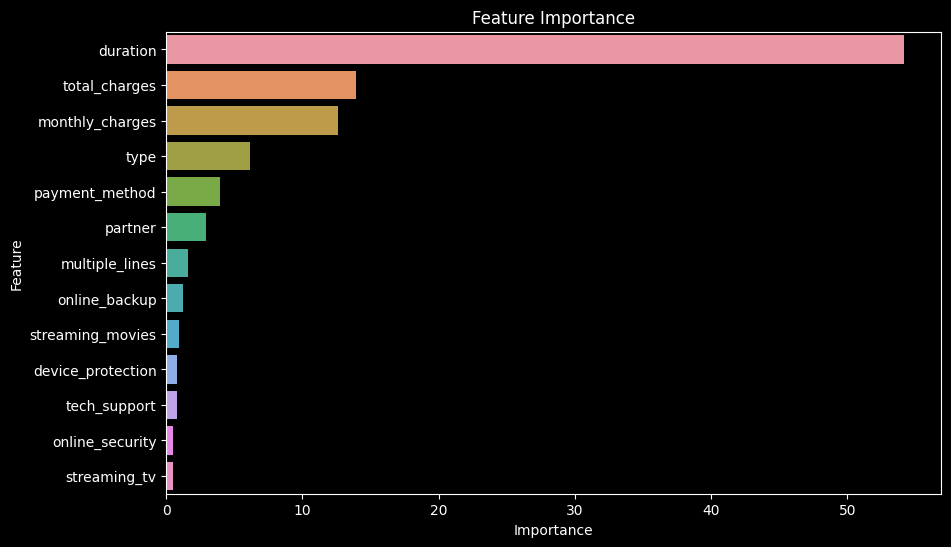

In [ ]:
# Get the importance of the features
feature_importances = cat_best_model.feature_importances_

# Create a Data Frame with the importance of features
feature_importance_df = pd.DataFrame({'Feature': X, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Build a graph of the importance of the features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Как мы видим для модели самыми важными признаками является:
+ продолжительность пользования услугами компании
+ общие траты пользователя
+ помесячные траты
+ тип подписки
+ тип оплаты
+ есть ли партнер

Остальные менее значимые, но также сыграли свою роль в предсказании и это с учетом исключения нескольких признаков, также можно провести дополнительное исследование со всеми признаками и дополнительно посмотреть прямое влияние признаков на предсказание с помощью библиотеки shap

### ROC-кривая

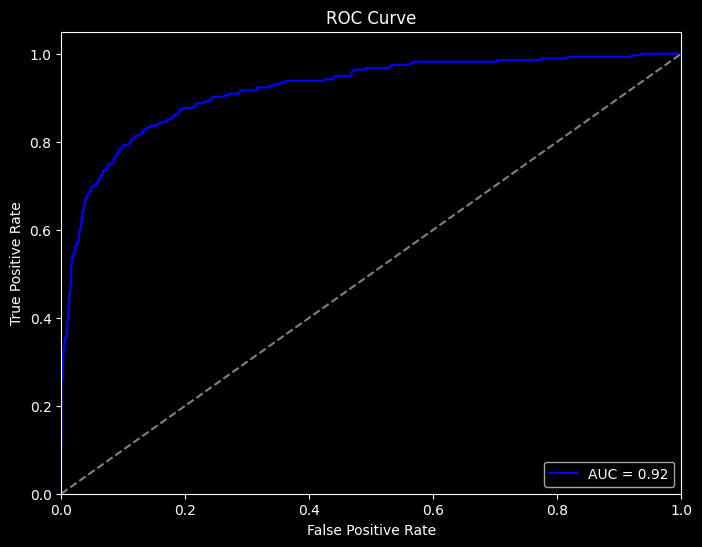

In [ ]:
# Calculate the FPR and TPR values for the ROC-curve
fpr, tpr, thresholds = roc_curve(test[y], pred_prob)

# Calculate the AUC-ROC value
roc_auc = roc_auc_score(test[y], pred_prob)

# Build a ROC-curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

 ROC-AUC равен 0.918, что говорит о том, что модель обладает высокой способностью разделять классы и имеет хорошие характеристики разделения между классами. Это позволяет довольно точно определить, когда модель делает верные и ложные предсказания, что подтверждается значительной площадью под кривой ROC

 Точки стремятся к левому верхнему углу, что является хорошим знаком.

### Матрица ошибок

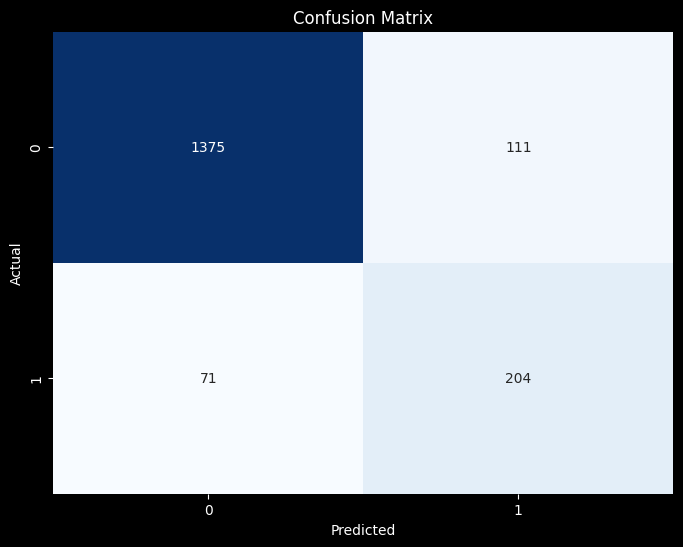

In [ ]:
# Get the predicted classes
pred_classes = cat_best_model.predict(test[X])

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test[y], pred_classes)

# Lets build a heat map of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

У нас получились достаточно маленькие ошибки, но также есть куда стремится

Модель предложила дать промокоды пользователям, которые не собирались уходить 111 раз (False Positive), на тестовой выборке (1761 наблюдение), которую она никогда не видела, что не критично, так как клиенты все равно остаются, хоть и получают скидку на услуги

Отточным клиентам она их не предлоожила 71 раз (False Negative), что достаточно хороший результат, нам важнее добиться минимальной ошибки False Negative, так как компания несет убытки больше именно из за ошибки второго рода, так как клиенты уходят

## Отчет

Мы проделали большую работу для решения задачи предсказания отточных клиентов, а именно:
+ Поняли и оценили задачу
  + Необходимо предсказать отточных пользователей с минимизацией ошибки второго рода то есть получить меньше всего ошибок на пользователях, которые ушли, а предсказание говорило об обратном
  + Главной болью заказчика является убытки связанные с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования
  + Выделены две болевые точки:
    + пользователю предложили промокоды, но он не собирался уходить (False Positive)
    + пользователю ничего не предложили и он ушёл (False Negative)
  + Определелили метрику для минимизации ошибки - ROC-AUC  
  + Также определили интерпретируемую метрику для заказчика - accuracy
+ Изучили данные
  + Выяснили, что выгруженные данные различаются по размеру выборок
  + Большинство признаков бинарные категориальные, также есть 2 признака с большим числом категорий
  + Были найдены ошибки выгрузки/сбора данных, а также работы предыдущей команды разработки
+ Предобработали данные
  + Объединили выборки в один датасет
  + Создали целевой признак отточности пользователей на основе признака даты окончания пользования услугами
  + Создали на основе двух неинформативных признаков дат новый признак продолжительность пользования услугами компании
  + В дальнейшем исключили эти два признака при обучении модели, так как они позволяют подглядеть в целевой признак
  + Исправили найденные ошибки на этапе осмотра данных
  + Заполнили пропуски в данных полученные после объединения разных по размеру выборок(приняли отсутствие пользователя в выборке за неиспользование услуги и проставили маркер 'No')
+ Провели исследование данных и выяснили:
  + Большинство услуг не используется пользователями, можем посоветовать пересмотреть условия по ним или сами услуги (возможно в этом и есть убыточность)
  + Пользователи по половому признаку и наличию партнера присутствуют примерно в равных количествах
  + Выделили два пика прихода пользователей в 2014 и 2019 году:
    + В первом случае были пиковые оплаты в связи с двухгодовой подпиской
    + Во втором большой приток пользователей был с подпиской на месяц (много пользователей, маленькое среднее значение общих оплат)
  + Провели анализ распределения средних значений суммарных платежей по пользователям, которые пользуются дополнительными сервисами
    +  Пользователи с интернет-сервисом DSL, не использующие сервисы потокового просмотра фильмов и телевидения, имеют самые низкие средние общие платежи (среднее: 1152.83) среди всех групп.
    + Пользователи с интернет-сервисом Fiber optic, которые используют оба сервиса потокового просмотра фильмов и телевидения, имеют самые высокие средние общие платежи (среднее: 4144.88) среди всех групп.
    + Пользователи с интернет-сервисом Fiber optic в целом имеют более высокие средние общие платежи по сравнению с пользователями DSL.
    + Группа с маркерами в столбцах 'internet_service', 'streaming_movies' и 'streaming_tv' (No) имеет самые низкие средние общие платежи (среднее: 626.98) по сравнению с другими группами с указанными услугами.
    + Эти наблюдения указывают на то, что тип интернет-сервиса и использование потоковых сервисов могут влиять на средние общие платежи пользователей.
    + Пользователи с интернет-сервисом Fiber optic, которые используют оба потоковых сервиса, имеют самые высокие платежи, в то время как пользователи с пропущенной информацией имеют самые низкие платежи в среднем.
  + Отточные пользователи чаще являются клиентами компании более  2-х с половиной лет (~915 дней)  
  + Отток пользователей с 2014 года только падает а новые пользователи растут
  + Определили описание среднего клиента компании:
    - Распределение пользователей по половому признаку примерно одинаково, также как и наличие партнера, так что это человек любого пола
    - Большинство - не пенсионеры и не имеют никого на иждивении
    - Основная часть пользователей используют оптоволокно, чуть меньше  пользователей подключены по DSL
    - Оплата помесячная
    - Получают счет за услуги на электронную почту и оплата в онлайн
    - Большая часть пользователей не пользуется дополнительными услугами компании
+ Исследовали модели
  + Разбили данные на выборки тренировочную (0.75% от исходной) и тестовую (0.25%)
  + Выделили необходимые признаки (дополнительно отделили категориальные признаки и целевой признак для преобразования в моделях)
  + Обучили бейзлайн модель - LogisicRegression
    + Подготовили признаки для модели с помощью конвейера (OHE для категориальных признаков, MinMaxScaler для непрерывных)
    + Перебрали параметры и сохранили лучшие
    + Получили метрики на кросс-валидации:
      + ROC-AUC = 0.77 - взяли это значение за порог, ниже которого метрики других моделей не будут иметь смысла
  + Обучили вторую модель - RandomForestClassifier
    + Подготовили признаки также с помощью конвейера (OrdinalEncoder для категориальных признаков, MinMaxScaler для непрерывных)
    + Перебрали параметры и также сохранили лучшие
    + Получили метрики на кросс-валидации:
      + ROC-AUC =  0.84 - что превзошло бейзлайн, но не дошло до порогового значения функции потерь
  + Обучили третью модель - CatBoostClassifier
    + Для этой модели нет необходимости делать какую либо предобработку, внутри она делает все сама и достаточно хорошо
    + Перебрали параметры на кросс-валидации
    + Получили метрику
      + ROC-AUC = 0.91 - что является лучшей метрикой в нашем исследовании
  + Занесли полученные данные исследования в таблицу результатов и выяснили
    + CatBoostClassifier - лучшая модель ее мы будем тестировать на тестовых данных, которых она еще не видела, чтобы оценить непредвзятое качество
    + CatBoostClassifier На 18.05 % превзошла бейзлайн-модель LogisticRegression
  + Провели тестирование модели и получили метрики:
    + ROC_AUC score: 0.918
    + Accuracy score: 0.897
  + Провели анализ модели
    + Разработали графики
      + Важности ошибок и выявили признаки которые влияли на обучение модели больше всего, а также предлагаем дополнительное исследования для повышения качества предсказаний
        + для модели самыми важными признаками является:
          + продолжительность пользования услугами компании
          + общие траты пользователя
          + помесячные траты
          + тип подписки
          + тип оплаты
          + есть ли партнер
          + Остальные менее значимые, но также сыграли свою роль в предсказании и это с учетом исключения нескольких признаков, также можно провести дополнительное исследование со всеми признаками и дополнительно посмотреть прямое влияние признаков на предсказание с помощью библиотеки shap
      + Построили ROC-кривую
        + ROC-AUC равен 0.918, что говорит о том, что модель обладает высокой способностью разделять классы и имеет хорошие характеристики разделения между классами. Это позволяет довольно точно определить, когда модель делает верные и ложные предсказания, что подтверждается значительной площадью под кривой ROC
        + Точки стремятся к левому верхнему углу, что является хорошим знаком
      + Привели матрицу ошибок
        + Получились достаточно маленькие ошибки, но также есть куда стремится
        + Модель предложила дать промокоды пользователям, которые не собирались уходить 111 раз (False Positive), на тестовой выборке (1761 наблюдение), которую она никогда не видела, что не критично, так как клиенты все равно остаются, хоть и получают скидку на услуги
        + Отточным клиентам она их не предлоожила 71 раз (False Negative), что достаточно хороший результат, нам важнее добиться минимальной ошибки False Negative, так как компания несет убытки больше именно из за ошибки второго рода, так как клиенты уходят


+ Вывод:

В этом отчете приведены основные этапы работы, а также некоторые тонкости в проведенном анализе, для воспроизводимости и интерпретации работы и дальнейшего использования модели в работе

Было достигнуто достаточно хорошее качество предсказаний и модель будет выполнять свою задачу хорошо, но также есть еще что можно улучшить


Спасибо!